<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\indi}{\mathbb{I}}
$$

In [29]:
# preamble
from graphviz import Digraph

# Transition-based dependency parsing

This chapter is influenced by the [EACL 2014 tutorial](http://stp.lingfil.uu.se/~nivre/eacl14.html) by Ryan McDonald and Joakim Nivre.

In the [parsing chapter](parsing.ipynb) we saw how to develop a syntactic parser based on context-free grammars (CFG). In this chapter we will see how to develop a syntactic parser based on a different paradigm, dependency parsing.

The key idea in dependency parsing is that syntactic structure of lexical items, linked by binary
asymmetric relations called dependencies. [Nivre, 2008](http://www.mitpressjournals.org/doi/pdf/10.1162/coli.07-056-R1-07-027) More simply, syntax is represented as directed edges between words. Thus unlike the trees in [CFG parsing](parsing.ipynb), dependency trees have only terminal nodes (the words of the sentences), which can appear as leaves as and non-leaf nodes. Here is the dependency graph for the sentence:

> "Economic news had little effect on financial markets"

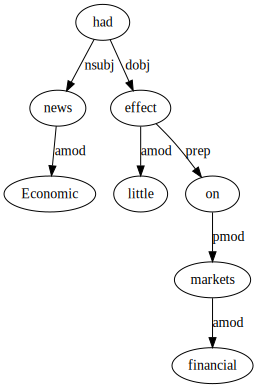

In [30]:
tokens = ["Economic", "news", "had", "little", "effect", "on", "financial", "markets"]
edges = [(2,1,"amod"),(3,2,"nsubj"), (3, 5, "dobj"), (5,4,"amod"), (5,6, "prep"), (6,8,"pmod"), (8,7,"amod")]

dot = Digraph(comment='The Round Table')

for token_id, token in enumerate(tokens):
    dot.node(str(token_id+1), token) #the +1 is to reserve 0 for the ROOT node, see later

for edge in edges:
    head, dep, label = edge
    dot.edge(str(head), str(dep), label)
    
    
dot

TODO: Formal description by Nivre, constraints

A straightforward approach to dependency parsing would be given a sentence \\(\x\\), to enumerate over all valid graphs for the sentence $\y\in\Ys_x$ and score them using an appropriate function \\(s_\params(\x,\y)\\), a case of a [structured prediction](structured_prediction.ipynb) problem. While such an approach is possible and there has been a lot of work often referred to as graph-based parsing, e.g. [McDonald et al. (2006)](http://www.ryanmcd.com/papers/MS-CIS-05-11.pdf), in this note we will focus on transition-based approaches, which decompose the task into a sequence of decisions that can be learned with a classifier.

To perform transition-based parsing we first need to define our transition system consisting of the following elements:

- Input:

- Configuration:
    - Arcs 
    - Buffer
    - Stack

- Actions:
    - shift
    - reduce
    - right-arc(label)
    - left-arc(label)

We further define two special configurations:
- initial
- terminal

TODO: Let's see how we can parse the example sentence using this transition system

In [ ]:
TODO: This blog post is quite good: https://spacy.io/blog/parsing-english-in-python

TODO: Sample transition system

TODO: Different transition systems: they consist of some elementary actions. The key thing is the learnability of the system: ambiguity is confusing.

TODO: Dynamic oracles to help with the ambiguity that we are left with, it was an implementation of the idea of expert policy from imitation learning (Searn/DAgger)

TODO: Non-projectivity with dual stacks and better visualisations